In [34]:
import numpy as np
from numpy import array  
from numpy.linalg import norm 
import scipy as sp
import scipy.fftpack
from matplotlib import pyplot as plt
import scipy.io
import math
from google.colab import drive

In [35]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generating 1-D DCT basis
------------------------


In [36]:
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = np.zeros((M, N)) # matrix containing the standard basis (a kronecker delta in each column)

for k in range(M):
    # take the formula from slides and remember to normalize. Each atom goes in a column of DCT matrix
    # ignoring ck's
    for n in range(M):
      DCT[n, k] = math.cos(k*math.pi*(2*n+1)/(2*M))
    normal = norm(DCT[:,k],2)
    DCT[:, k] = DCT[:,k]/normal
   

Display an atom of the dct basis

Text(0.5, 1.0, 'element: 35 from the DCT basis')

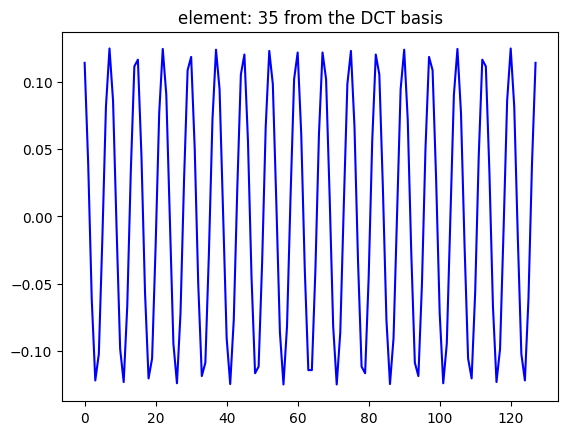

In [37]:
k = 34
plt.figure()
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis')

Check orthogonality

In [38]:
mult = DCT.T @ DCT
is_DCT_orth = np.all(abs(mult - np.identity(M)) < 0.0001)
print(f'DCT dictionary is orthogonal: {is_DCT_orth}')

DCT dictionary is orthogonal: True


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

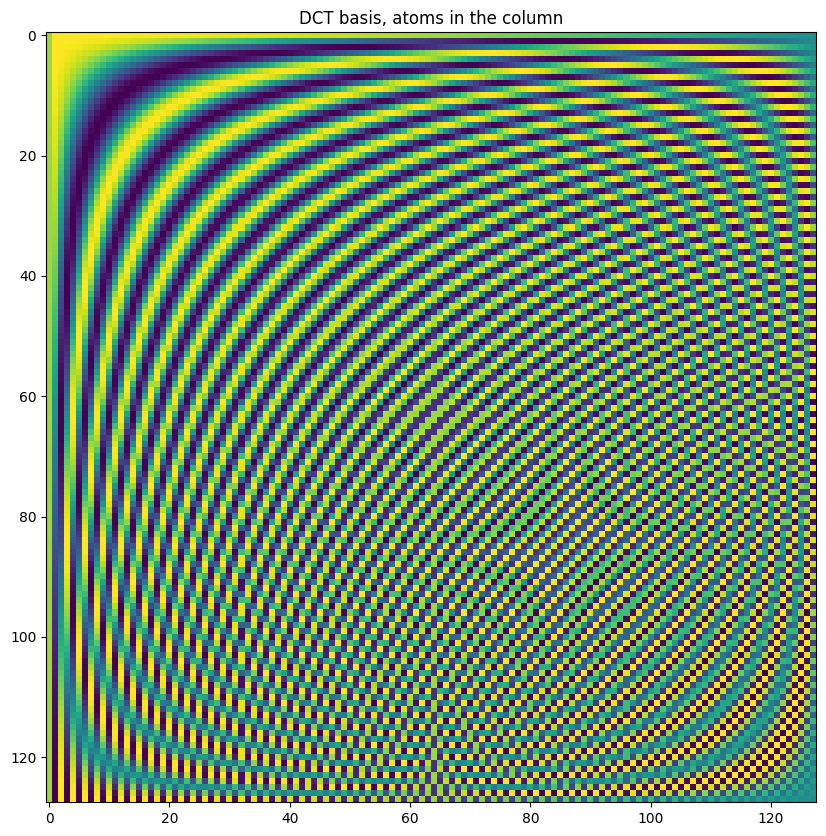

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Generate 1D DCT basis using the function idct 
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [40]:
for k in range(M):
    # define the atom
    a = np.zeros(M)
    a[k] = 1
    D[:, k] = sp.fftpack.idct(a, norm='ortho')

Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

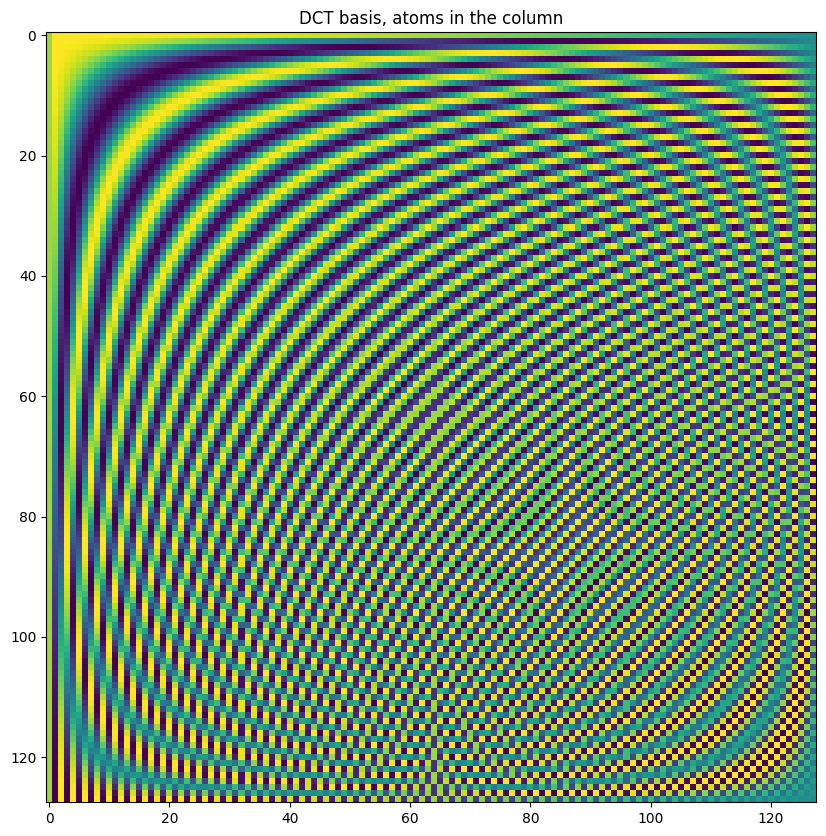

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Check that D and DCT defined above coincide

In [42]:
is_DCT_equal_D = np.all(abs(DCT - D < 0.001))
print(f'D and DCT are equal: {is_DCT_equal_D}')

D and DCT are equal: True


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [43]:
temp = scipy.io.loadmat(f'{rootfolder}/data/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
coeffD = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [44]:
# for i in range(nBeats):
#     coeffD[:, i] = np.matmul(np.transpose(D),S[:,i])
# without the for loop: 
coeffD= D.T @ S

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

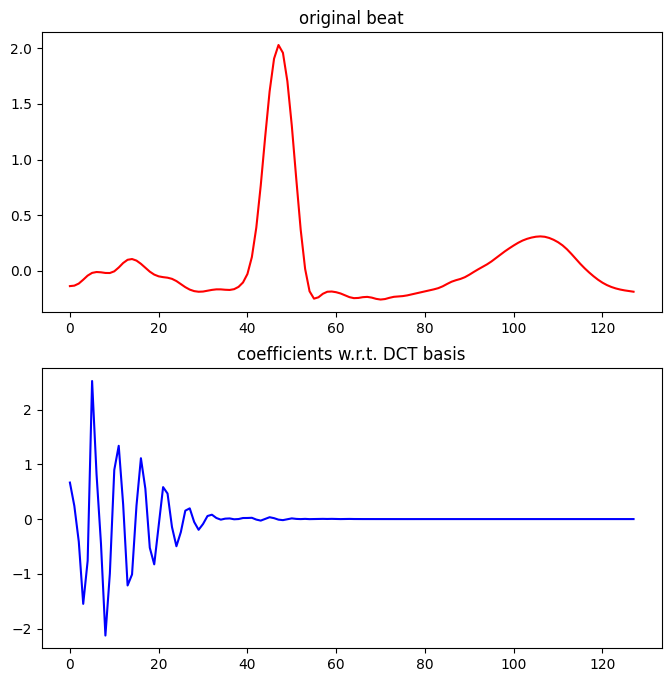

In [45]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(coeffD[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [46]:
S_hat_D = D@coeffD

Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [47]:
is_reconstruction_perfect = np.all(abs(S_hat_D - S) < 0.000001)
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')

The reconstruction is perfect: True


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [48]:
sigma_noise = 0.1
S0 = S.copy()
S = S0 + sigma_noise * np.random.normal(size=S0.shape)

coeffD = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D


Compute the representation coefficients

In [49]:
# for i in range(nBeats):
#     coeffD[:, i] = np.transpose(D)@S[:,i]
# without the for loop: 
coeffD= D.T @ S

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

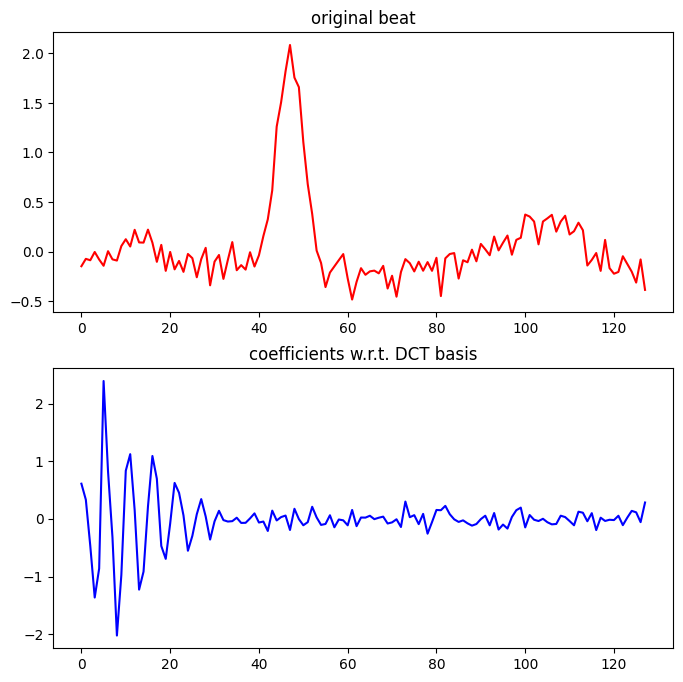

In [50]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(coeffD[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only few coefficients having largest magnitude

In [51]:
coeff_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M, nBeats))
L = 25 # sparsity level (try different values)

for i in range(nBeats):
    origSignal = S0[:,i]
    noisySignal = S[:,i]

    # transform each signal separately (analysis)
    coeff_original = D.T@origSignal
    coeff_noisy = D.T@noisySignal

    # keep only the L largest coefficients (absolute value)
    indices = np.argpartition(abs(coeff_noisy), -L)[-L:] 
    #Find the L biggest in each column
    coeff_HT[:,i] = np.zeros(M)
    coeff_HT[indices,i] = coeff_noisy[indices]
    
    # invert the transformation
    s_hat = D @ coeff_HT[:,i]

    S_hat[:, i] = s_hat
    

Display a signal

Text(0.5, 1.0, 'DCT coefficients')

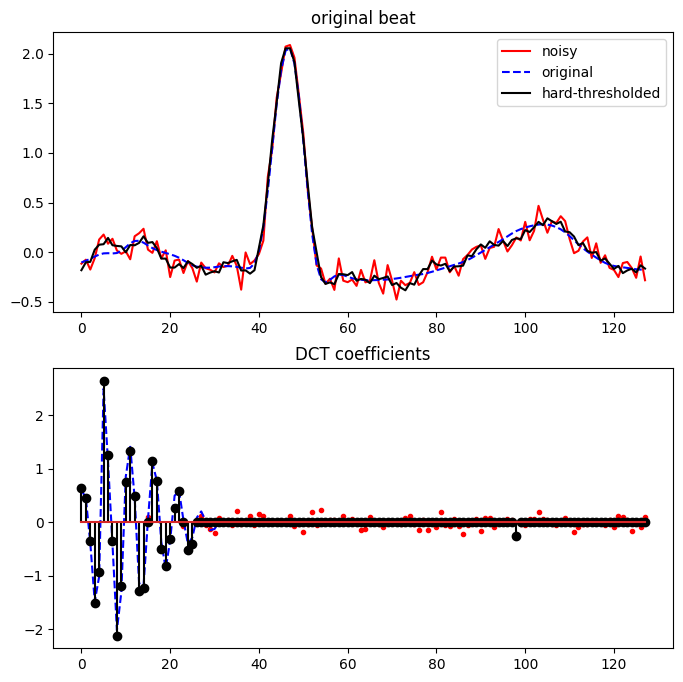

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.plot(S0[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), coeff_HT[:, i], 'k')
ax2.set_title('DCT coefficients')

Plot representation of MSE wrt sparsity level
----------




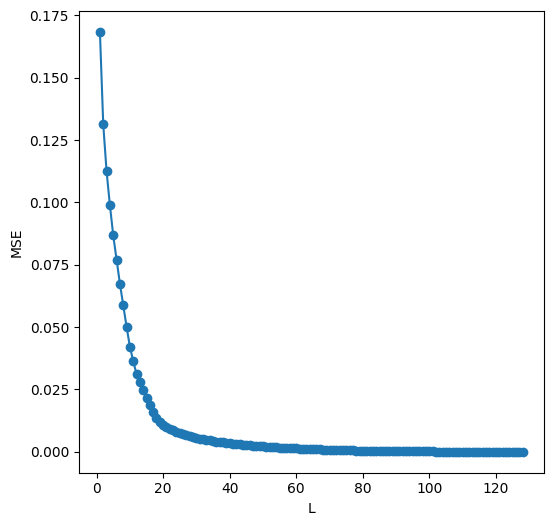

In [53]:
coeff_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M))

L_values = np.arange(1, M+1)
MSE_values = np.zeros(M)

origSignal = S[:, 0]

for L in L_values:
     # transform each signal separately (analysis)
    coeff = D.T@origSignal

    # keep only the L largest coefficients (absolute value)
    indices = np.argpartition(abs(coeff), -L)[-L:] 
    
    coeff_HT = np.zeros(M)
    coeff_HT[indices] = coeff[indices]

    # invert the transformation
    s_hat = D @ coeff_HT

    mse = 1/M* sum((S[:,0]-s_hat)**2)

    MSE_values[L-1] = mse

plt.figure(figsize=(6,6))
plt.plot(L_values, MSE_values, '-o')
plt.xlabel("L")
plt.ylabel("MSE")
plt.show()
